In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sys, pathlib

# project root (parent of Notebooks/) so `from Code...` works
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale
from Code.resampling import bootstrap_predictions, bias_variance_from_preds
from Code.models import fit_ols, predict_from_theta

/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.095e-02, tolerance: 1.202e-03
  model = cd_fast.enet_coordinate_descent(
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e-01, tolerance: 1.206e-03
  model = cd_fast.enet_coordinate_descent(
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linea

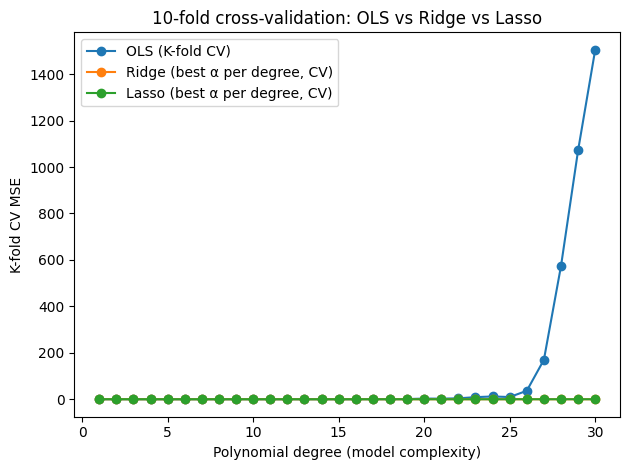

In [20]:
# ----- data -----
rng = np.random.default_rng(1)
x, y = make_data(n=80, noise_sd=0.20, seed=1)          
X = x.reshape(-1, 1)                                   

deg_max = 30
degrees = list(range(1, deg_max + 1))
K = 10
cv = KFold(n_splits=K, shuffle=True, random_state=1)

def cv_curve(model, degrees, X, y, cv):
    """Return mean and std of K-fold MSE across degrees for a given base model."""
    means, stds = [], []
    for d in degrees:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("model", model)
        ])
        # sklearn returns NEGATIVE MSE; flip the sign
        scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
        means.append(scores.mean())
        stds.append(scores.std(ddof=1))
    return np.array(means), np.array(stds)

# OLS
mse_ols, sd_ols = cv_curve(LinearRegression(fit_intercept=True), degrees, X, y, cv)

# Ridge: pick best alpha per degree from a small grid (simple inner sweep)
alphas_ridge = np.logspace(-4, 2, 9)   # 1e-4 ... 1e2
mse_ridge = []
for d in degrees:
    best = np.inf
    for a in alphas_ridge:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=a, fit_intercept=True, random_state=1))
        ])
        scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
        best = min(best, scores.mean())
    mse_ridge.append(best)
mse_ridge = np.array(mse_ridge)

# Lasso: same idea (increase max_iter to ensure convergence)
alphas_lasso = np.logspace(-4, 1, 10)  # 1e-4 ... 10
mse_lasso = []
for d in degrees:
    best = np.inf
    for a in alphas_lasso:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("model", Lasso(alpha=a, fit_intercept=True, max_iter=20000, random_state=1))
        ])
        scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
        best = min(best, scores.mean())
    mse_lasso.append(best)
mse_lasso = np.array(mse_lasso)

# ----- plot -----
plt.figure()
plt.plot(degrees, mse_ols,   marker="o", label="OLS (K-fold CV)")
plt.plot(degrees, mse_ridge, marker="o", label="Ridge (best α per degree, CV)")
plt.plot(degrees, mse_lasso, marker="o", label="Lasso (best α per degree, CV)")
plt.xlabel("Polynomial degree (model complexity)")
plt.ylabel("K-fold CV MSE")
plt.title(f"{K}-fold cross-validation: OLS vs Ridge vs Lasso")
plt.legend(); plt.tight_layout()

#plt.savefig(f"figures/cv_mse_k{K}.png", dpi=300, bbox_inches="tight")  # save

plt.savefig(fig_dir / "cv_mse.png", dpi=300, bbox_inches="tight")




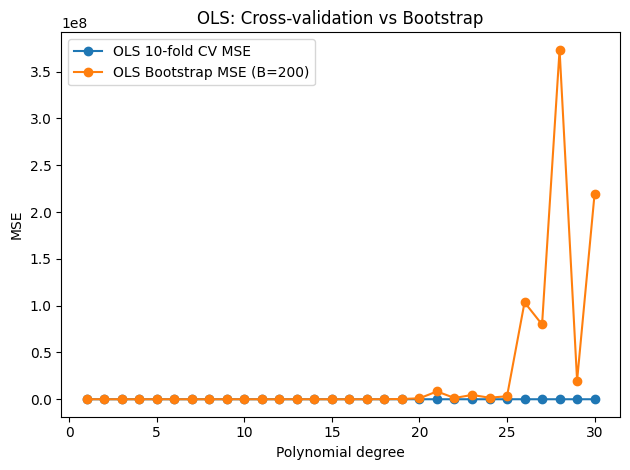

In [21]:
# ----- bootstrap "test MSE" on a fixed split (OLS only, as you did) -----
split = lambda X,Y: split_and_scale(X, Y, test_size=0.3, random_state=1, center_y=True) 

X_full = build_features(x, degree=deg_max, include_bias=False)
X_tr_s, X_te_s, y_tr_c, y_te, _, y_mean = split(X_full, y)

B = 200
mse_boot = []
for p in degrees:
    P = bootstrap_predictions(
        fit_fn=fit_ols,
        pred_fn=predict_from_theta,
        Xtr_s=X_tr_s[:, :p],
        ytr_c=y_tr_c,
        Xte_s=X_te_s[:, :p],
        y_mean=y_mean,
        B=B, seed=1
    )
    _, _, mse_p = bias_variance_from_preds(P, y_true=y_te.ravel())
    mse_boot.append(mse_p)
mse_boot = np.array(mse_boot)

# ----- overlay plot: CV vs Bootstrap (OLS) -----
plt.figure()
plt.plot(degrees, mse_ols,  marker="o", label=f"OLS {K}-fold CV MSE")
plt.plot(degrees, mse_boot, marker="o", label=f"OLS Bootstrap MSE (B={B})")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("OLS: Cross-validation vs Bootstrap")
plt.legend(); plt.tight_layout()

plt.savefig(fig_dir / "OLS_cv_vs_bootstrap.png", dpi=300, bbox_inches="tight")

